In [47]:
from PIL import Image
from google.colab import userdata
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pandas as pd
import matplotlib.pyplot as plt

import json
import os

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    print(line)
    return



# Paths

In [44]:
project_path = userdata.get('PATH_PROJECT')
dataset_path = os.path.join(project_path, 'dataset')
metadata_path = os.path.join(dataset_path, 'dataset_metadata.json')


# Dataset / Dataloader

```
[
    {
        "unique_sample_id": "new_Fuziki_case10_2789_2650",
        "clean_image": 4547604,
        "distorted_image": 4547601,
        "score": 0,
        "metadata": {
            "crop_id": 4547601,
            "image_source": "Fuziki",
            "bp_case": "case10",
            "method": "new",
            "color": "RED",
            "score": 0,
            "roi": [
                    2650,
                    2789,
                    20,
                    20
                ],
            "bp_map": 4547603,
            "IQE_workspace_number": 990
        }
    }
]
```

In [45]:

class PairedImageDataset(Dataset):
    """
    Dataset that returns pairs of images (clean, new) or (clean, ref) along with their score label.

    Args:
        root_dir (str): Directory with subfolders 'clean', 'new', 'ref'.
        metadata_json_path (str): Path to JSON file of the form:
            [
                {
                    "unique_sample_id": "new_Fuziki_case10_2789_2650",
                    "clean_image": 4547604,
                    "distorted_image": 4547601,
                    "score": 0,
                    "metadata": {
                        ...
                    }
                },
                ...
            ]
        transform (callable, optional): Transform to apply to both images.
    """
    def __init__(self, root_dir, metadata_json_path, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Load metadata
        self.meta = pd.read_json(metadata_json_path)

        # Build list of (clean_path, other_path, score)
        self.samples = []
        for _, row in self.meta.iterrows():
            clean_id = str(row['clean_image'])
            distorted_id = str(row['distorted_image'])
            method = row['metadata']['method']
            score = row['score']

            # make triples (clean path, distorted path, score)
            clean_path = os.path.join(root_dir, 'clean', f'{clean_id}.png')
            distorted_path = os.path.join(root_dir, method, f'{distorted_id}.png')

            if os.path.exists(distorted_path):
                self.samples.append((clean_path, distorted_path, score))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        clean_path, other_path, score = self.samples[idx]
        img_clean = Image.open(clean_path)
        img_other = Image.open(other_path)

        if self.transform:
            img_clean = self.transform(img_clean)
            img_other = self.transform(img_other)

        return img_clean, img_other, score




Batch 0: clean torch.Size([16, 3, 20, 20]), paired torch.Size([16, 3, 20, 20]), scores tensor([0.5000, 1.0000, 0.0000, 0.5000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 0.5000, 0.5000, 0.0000],
       dtype=torch.float64)


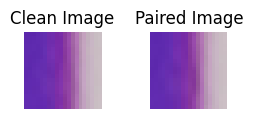

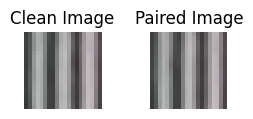

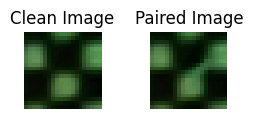

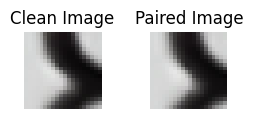

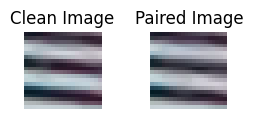

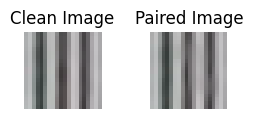

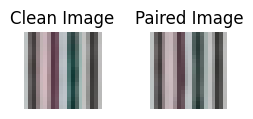

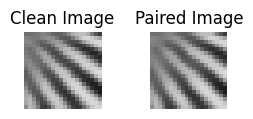

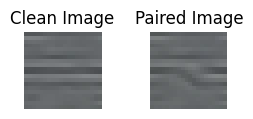

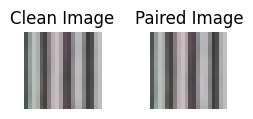

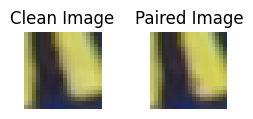

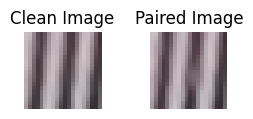

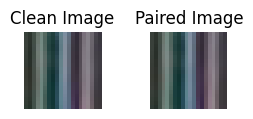

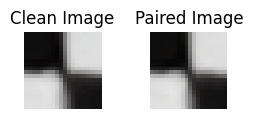

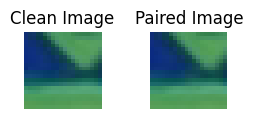

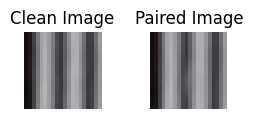

In [64]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create dataset and dataloader
dataset = PairedImageDataset(dataset_path, metadata_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

# Iterate
for batch_idx, (clean_imgs, paired_imgs, scores) in enumerate(dataloader):
    print(f"Batch {batch_idx}: clean {clean_imgs.shape}, paired {paired_imgs.shape}, scores {scores}")
    # break after first batch
    for clean, distorted in zip(clean_imgs, paired_imgs):
        # Convert tensors to PIL Images
        clean_pil = to_pil_image(clean)
        distorted_pil = to_pil_image(distorted)

        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(3, 1))

        # Display the images side by side
        axes[0].imshow(clean_pil)
        axes[0].set_title("Clean Image")
        axes[0].axis('off')

        axes[1].imshow(distorted_pil)
        axes[1].set_title("Paired Image")
        axes[1].axis('off')

        plt.show()
    break